# Relax Data Science Challenge

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from scipy.stats import chi2_contingency

## Define an 'adopted user'

First, I will read the data, and manipulate it to have a column 'adopted' for each user row

In [2]:
# Read user_engagement in user_engage dataframe
user_engage = pd.read_csv('takehome_user_engagement.csv', header=0, parse_dates=True, 
                          index_col='time_stamp')

In [3]:
# Extract day from each time_stamp
user_engage['day'] = user_engage.index.floor('D')

In [4]:
# Drop visits from the same user occuring on the same day 
# because we need visits on separate days
user_engage = user_engage.drop_duplicates()

In [5]:
# Pivot table to get the visits per user (columns) per day (index)
# Since we dropped the duplicates, we can only have 0 or 1 in this table
user_engage = user_engage.pivot_table(index='day', columns='user_id', 
                                      values='visited', aggfunc='sum').fillna(0)

In [6]:
# calculate the number of visits for each user in a 7 days rolling window
user_engage = user_engage.rolling('7D').sum()

In [7]:
# Unpivot the table to have a column of users
user_engage = user_engage.melt(var_name='user_id',value_name='visited_in_7D')

In [8]:
# Group by users and keep only the maximum number of visits on a 7 day rolling window
user_engage = user_engage.groupby('user_id').max()

In [9]:
# Add the column'adopted' if the maximum number of visits is at least 3
user_engage['adopted'] = 0
user_engage.adopted[user_engage.visited_in_7D>2] = 1

/Users/tisonbertrand/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
# Drop the column 'visited_in_7D'
user_engage = user_engage.drop(columns='visited_in_7D')

In [11]:
# Read the users data in users dataframe
users = pd.read_csv('takehome_users.csv', header=0, parse_dates=True, 
                    encoding='mac_roman', index_col='object_id')

In [12]:
# join user_engage (adopted column) to users dataframe 
users = users.join(user_engage, how='left')

In [13]:
# Fill NaN with 0 for users who are not in user_engage table 
# (they did not visit at all)
users.adopted = users.adopted.fillna(0)

In [14]:
# Change creation_time into datetime 
users.creation_time = pd.to_datetime(users.creation_time)

In [15]:
# Change last_session_user_time into a timestamp
for idx in users.index.values:
    if pd.notna(users.loc[idx,'last_session_creation_time']):
        users.loc[idx,'last_session_creation_time'] = pd.Timestamp.utcfromtimestamp(users.loc[idx,'last_session_creation_time'])
        

In [16]:
# Replace missing invited_by_user_id by 0
# So we can see this "no invite" feature in the exploration
#users.invited_by_user_id = users.invited_by_user_id.fillna(0)

In [17]:
# Add non_adopted column to ease data exploration 
users['non_adopted'] = 1-users.adopted

In [18]:
users.head().T

object_id,1,2,3,4,5
creation_time,2014-04-22 03:53:30,2013-11-15 03:45:04,2013-03-19 23:14:52,2013-05-21 08:09:28,2013-01-17 10:14:20
name,Clausen August,Poole Matthew,Bottrill Mitchell,Clausen Nicklas,Raw Grace
email,AugustCClausen@yahoo.com,MatthewPoole@gustr.com,MitchellBottrill@gustr.com,NicklasSClausen@yahoo.com,GraceRaw@yahoo.com
creation_source,GUEST_INVITE,ORG_INVITE,ORG_INVITE,GUEST_INVITE,GUEST_INVITE
last_session_creation_time,2014-04-22 03:53:30,2014-03-31 03:45:04,2013-03-19 23:14:52,2013-05-22 08:09:28,2013-01-22 10:14:20
opted_in_to_mailing_list,1,0,0,0,0
enabled_for_marketing_drip,0,0,0,0,0
org_id,11,1,94,1,193
invited_by_user_id,10803,316,1525,5151,5240
adopted,0,1,0,0,0


## Explore users data

### How many users are adopted?

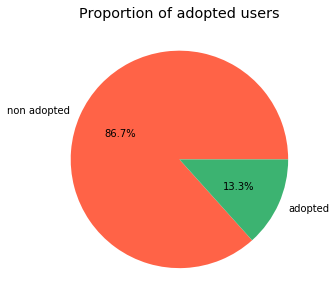

In [19]:
# pie plot of adopted vs. non adopted users
plt.figure(figsize=(5,5))
adopted_prop = users.adopted.value_counts().sort_index()
plt.pie(adopted_prop.values,labels=['non adopted','adopted'],colors=['tomato','mediumseagreen'], autopct='%1.1f%%')
plt.title('Proportion of adopted users')
plt.show()

### What are the factors to predict user adoption?

In [20]:
def plot_time(users,col):
    """Plot the number of adopted and non_adopted users vs time"""
    t = pd.DataFrame(users[['adopted','non_adopted']].values, columns=['adopted', 'non_adopted'], index=users[col])
    t = t.resample('M').sum().fillna(0)
    plt.figure(figsize=(10,5))
    plt.plot(t.index,t.adopted, color='mediumseagreen')
    plt.plot(t.index,t.non_adopted, color='tomato')
    plt.title('Users status vs ' + col)
    plt.show()
    return

/Users/tisonbertrand/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


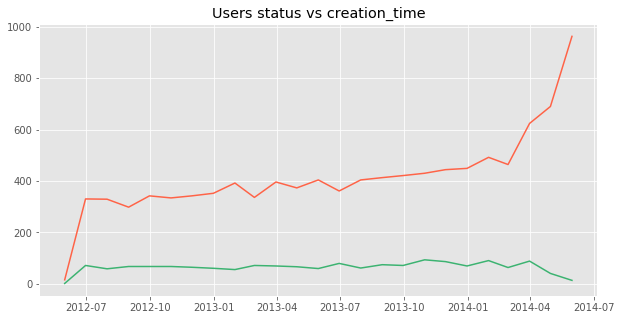

In [21]:
plot_time(users,'creation_time')

The adopted users are stable. When the creation_time is more recent, the users are less likely to be adopted. But maybe they did not have enough time to be adopted.

However, we can notice that the number of users who create an account has been constantly growing, and has almost doubled in the first 6 months of 2014. 

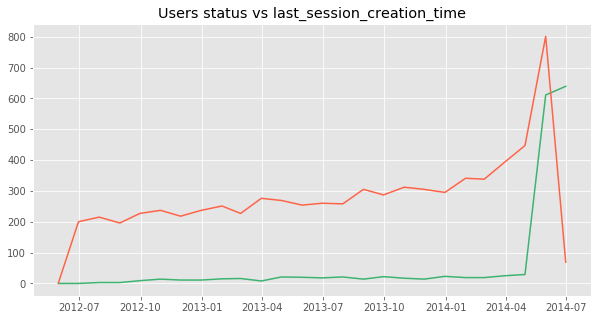

In [22]:
plot_time(users,'last_session_creation_time')

In the recent logins, there is a high proportion of adopted users. This is not surprising that adopted users logged in recently.

The high number of non adopted users who logged in recently matches the number of users recently created.

In [23]:
def plot_cat(users,col):
    """Plot a bar plot of the adopted rate per category of users"""
    c = users.groupby(col)[['adopted','non_adopted']].sum()
    c['adoption_rate'] = c.adopted/(c.adopted+c.non_adopted)*100
    plt.figure(figsize=(10,5))
    plt.bar(c.index.values, c.adoption_rate.values, color='mediumseagreen')
    plt.xticks(range(len(c.index.values)),c.index.values)
    plt.ylabel('Adoption rate (%)')
    plt.title('Adoption rate vs ' + col)
    plt.show()

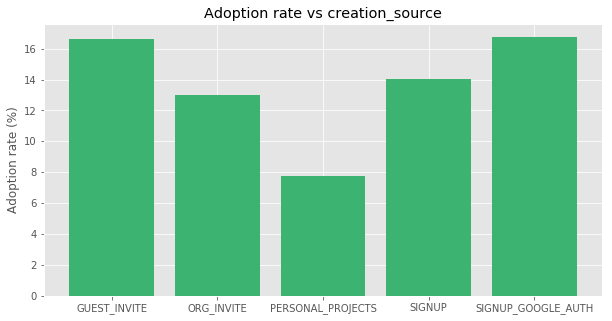

In [24]:
plot_cat(users,'creation_source')

The best adoption rates are for GUEST_INVITE and SIGNUP_GOOGLE_AUTH.
The worst adoption rate is for PERSONAL_PROJECTS

Creation_source can be used to predict user adoption.

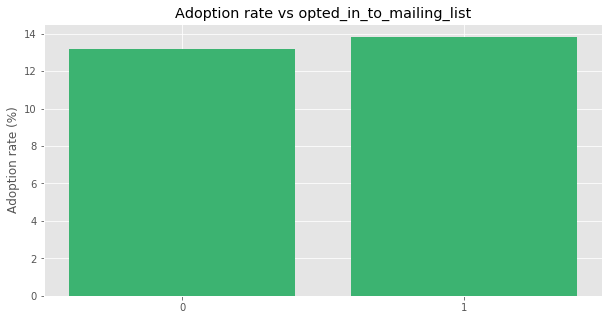

In [25]:
plot_cat(users,'opted_in_to_mailing_list')

There is not much difference between these categories.

Opted_in_to_mailing_list is not a good feature to predict user adoption

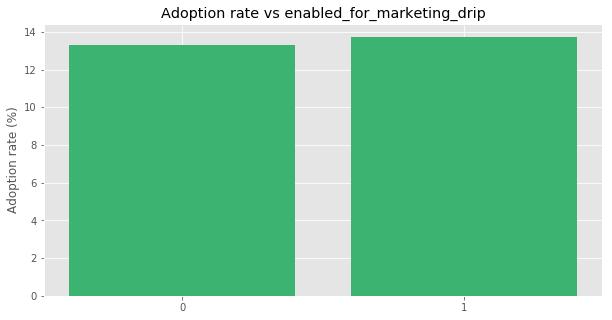

In [26]:
plot_cat(users,'enabled_for_marketing_drip')

There is not much difference between these categories.

Enabled_for_marketing_drip is not a good feature to predict user adoption

To see if the proportion of adopted is similar for each org_id, I will use chi2 contingency test.

In [27]:
# First, get the contingency table: number of adopted / non_adopted for each org_id 
org_id = users.groupby('org_id')[['adopted','non_adopted']].sum()
# Then, calculate the chi2 test
chi2, p, dof, expected = chi2_contingency(org_id.values)
print("chi2: {:f}, degree of freedom: {:d}, p_value: {:f}".format(chi2,dof,p))

chi2: 539.010304, degree of freedom: 416, p_value: 0.000043


These results show we can reject the null hypothesis that the proportion of adopted is similar for any org_id.

The org_id can be used to predict user adoption.

In [28]:
# Print the top 5 of best organizations for user adoption rate:
org_id['adoption_rate'] = org_id.adopted / (org_id.adopted+org_id.non_adopted) *100
org_id = org_id.sort_values(by=['adoption_rate'], ascending=False)
org_id.head()

,adopted,non_adopted,adoption_rate
org_id,,,
387,7.0,5.0,58.333333
235,6.0,7.0,46.153846
270,6.0,8.0,42.857143
399,5.0,8.0,38.461538
392,6.0,10.0,37.500000


To see if the proportion of adopted is similar for each user_id, I will use chi2 contingency test.

In [29]:
# First, get the contingency table
invited_by_user_id = users.groupby('invited_by_user_id')[['adopted','non_adopted']].sum()
# Then, calculate the chi2 test
chi2, p, dof, expected = chi2_contingency(invited_by_user_id.values)
print("chi2: {:f}, degree of freedom: {:d}, p_value: {:f}".format(chi2,dof,p))

chi2: 2618.850630, degree of freedom: 2563, p_value: 0.216585


These results show we can not reject the null hypothesis that the proportion of adopted is similar for any invited_by_user_id.

However, since half of the users have no invite, we couild check if there is a difference between users with invitation and users without invitation.

/Users/tisonbertrand/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


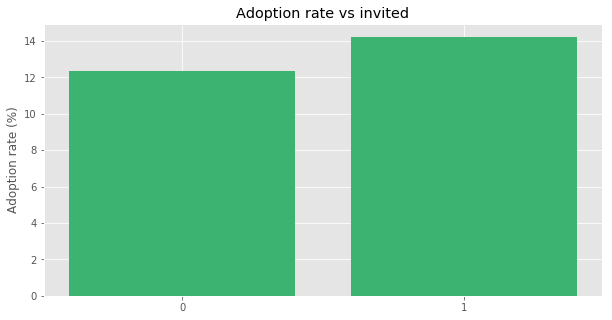

In [30]:
users['invited'] = 1
users.invited[users.invited_by_user_id.isna()] = 0
plot_cat(users,'invited')

We can use whether the user is invited ot not as a feature for prediction.

## Conclusion

The proportion of adopted users is 13.3% for this dataset.

The factors to predict future user adoption are:

- how the account was created: users invited to an organization as a guest or who signed up using Google authentication are more likely to be adopted. Users invited to join another user’s personal workspace are less likely to be adopted


- organization the user belongs to: the statistical test shows the proportion of adopted is different according to organization. The top 5 organizations for best adoption rate 387, 235, 270, 399 and 415.


- whether the user was invited to join or not. Users invited to join by another user are more likely to be adopted.


We can also notice that the number of users who create an account has been constantly growing, and has almost doubled in the first 6 months of 2014.
